## Comparative Analysis of Time Series Forecasting Using Classical Statistical Methods and Advanced Machine Learning Models


These plots are illustrating the characteristics of the given time series data.


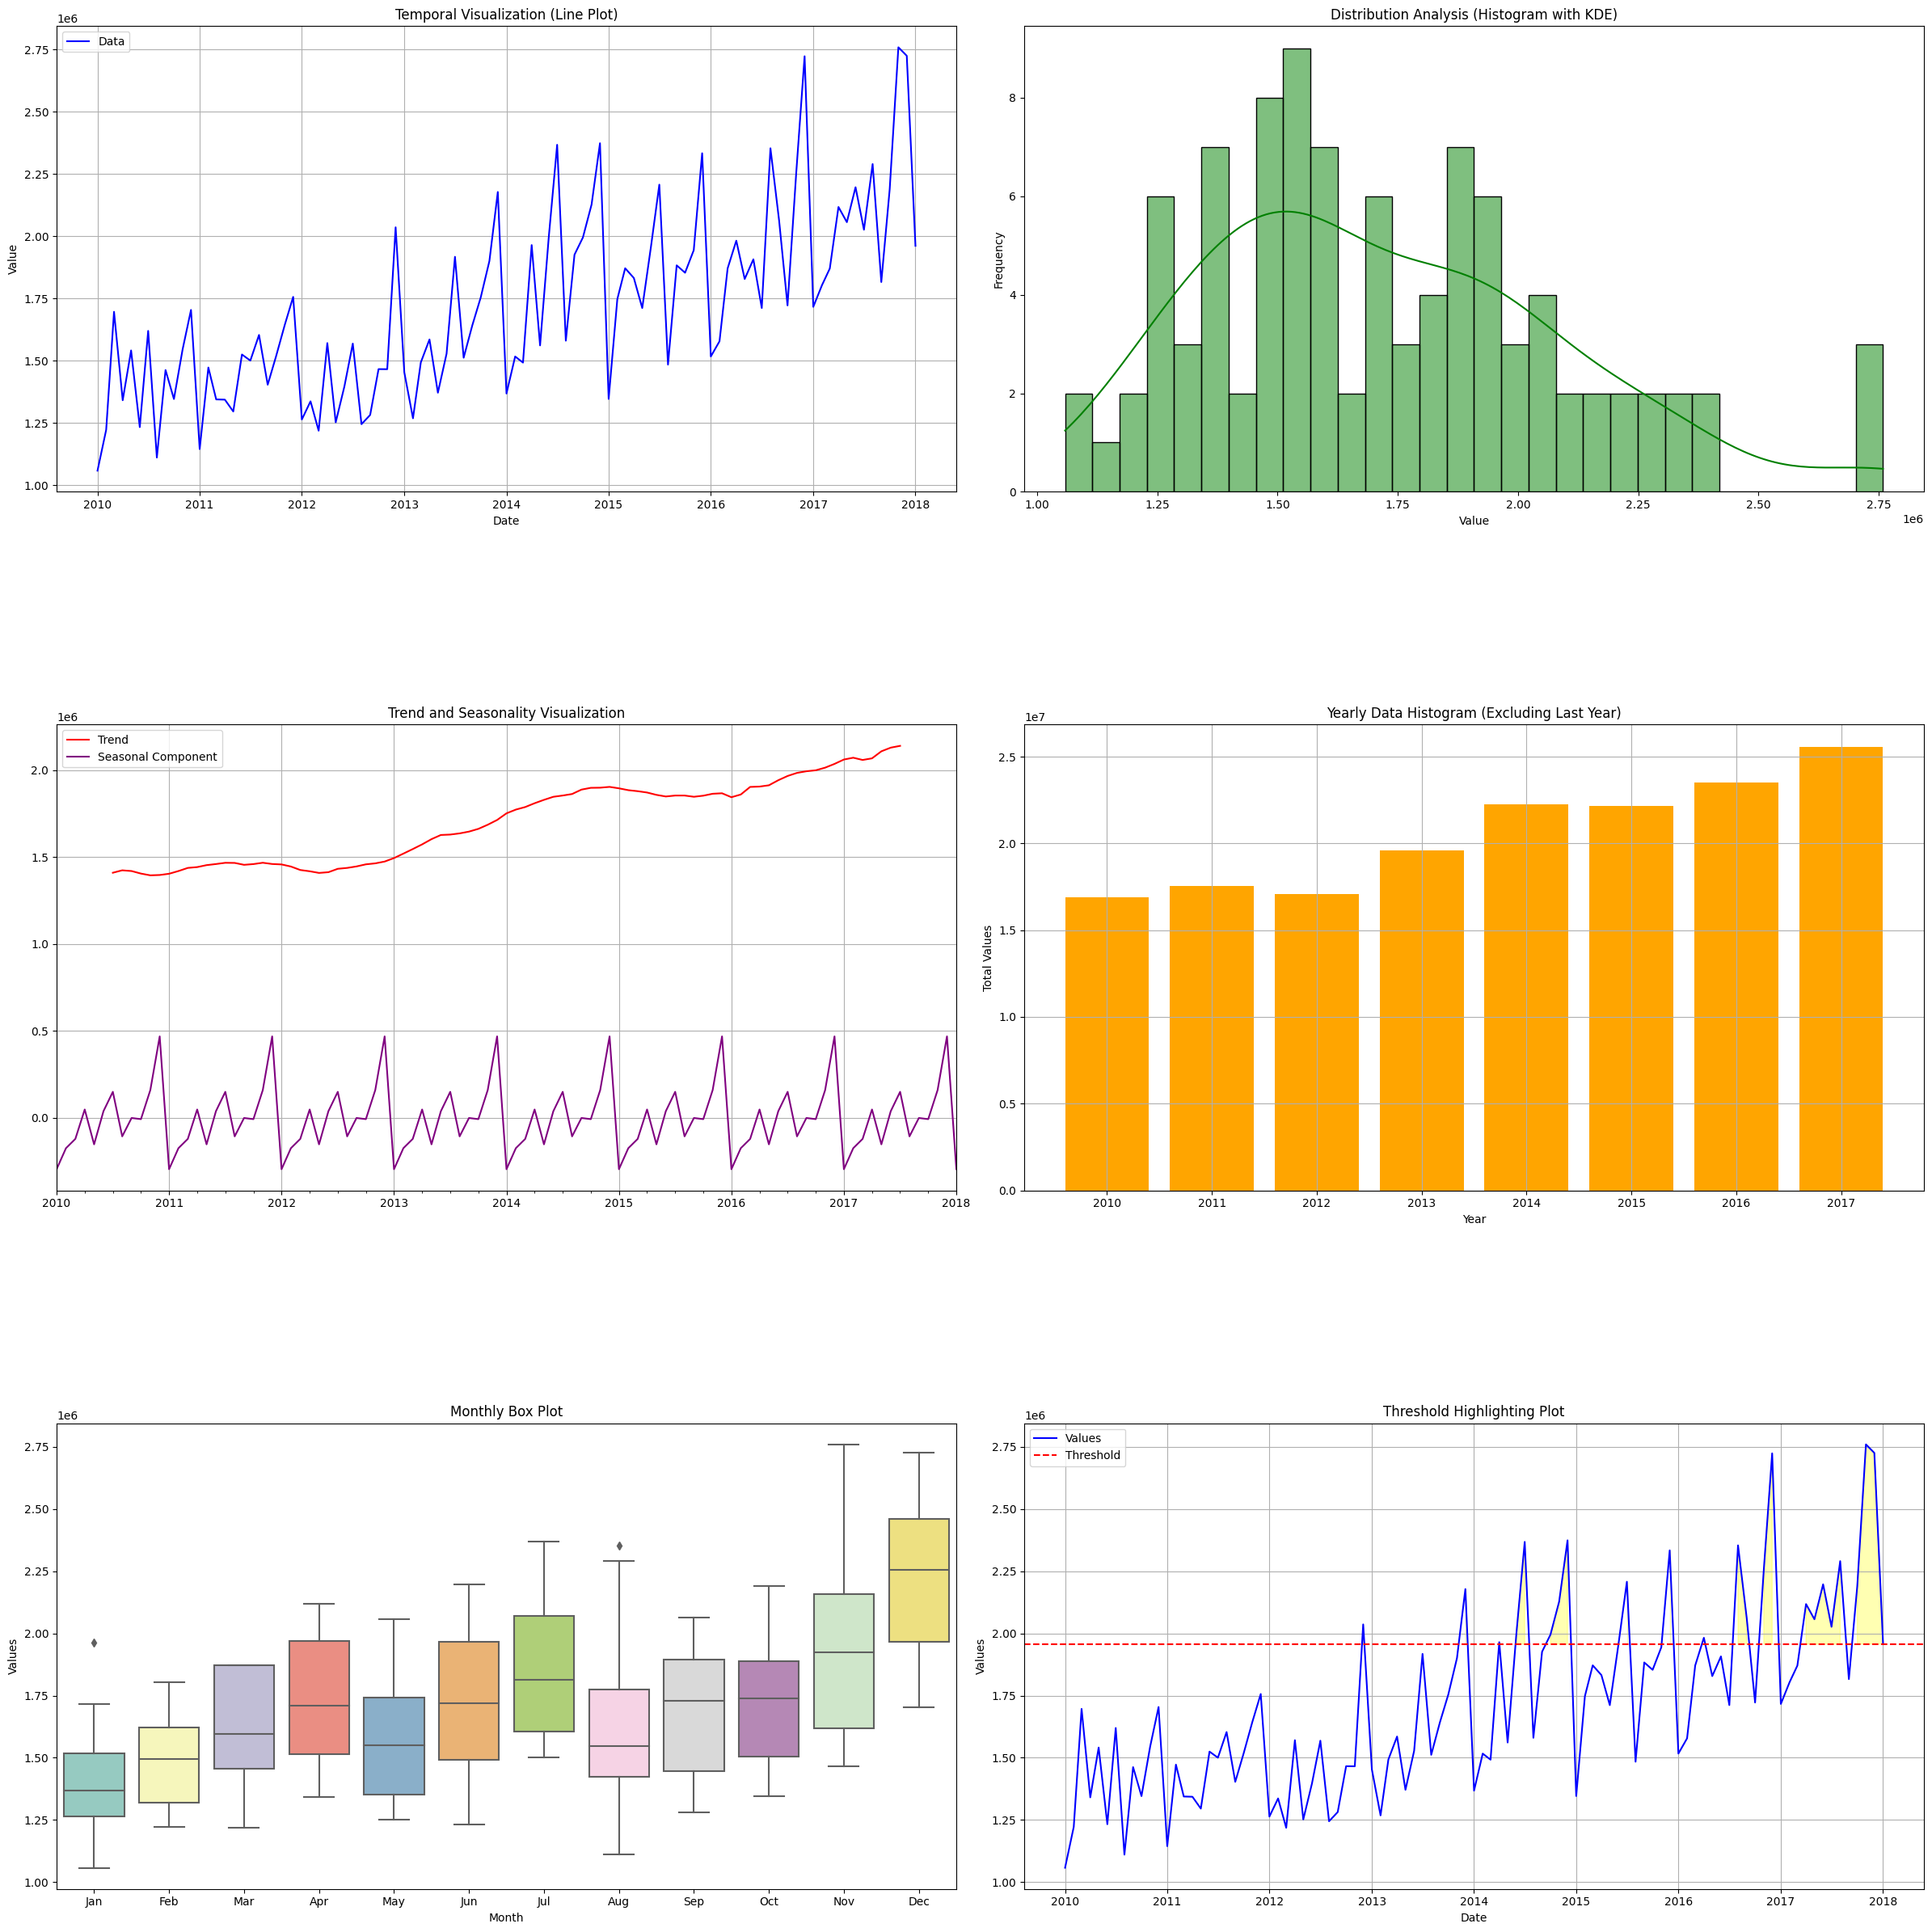

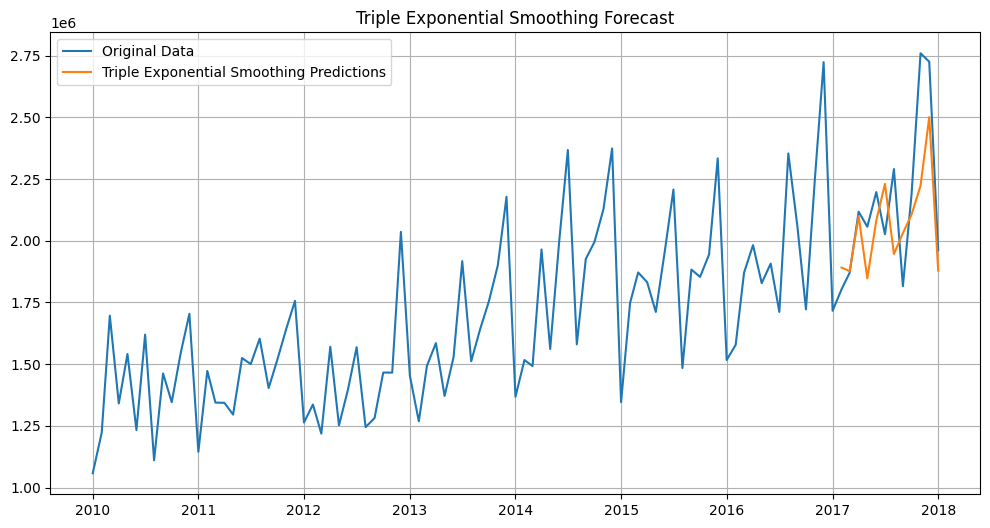

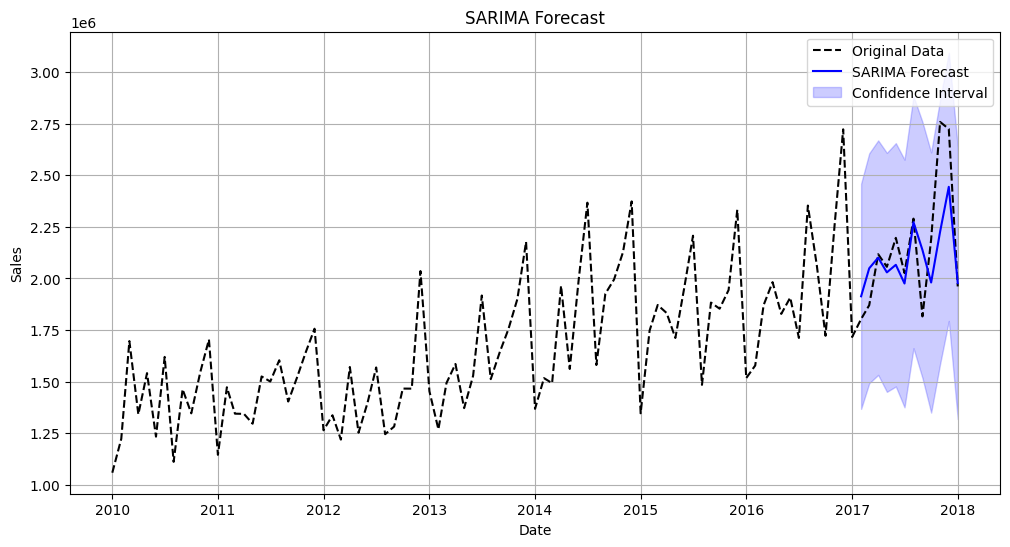

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


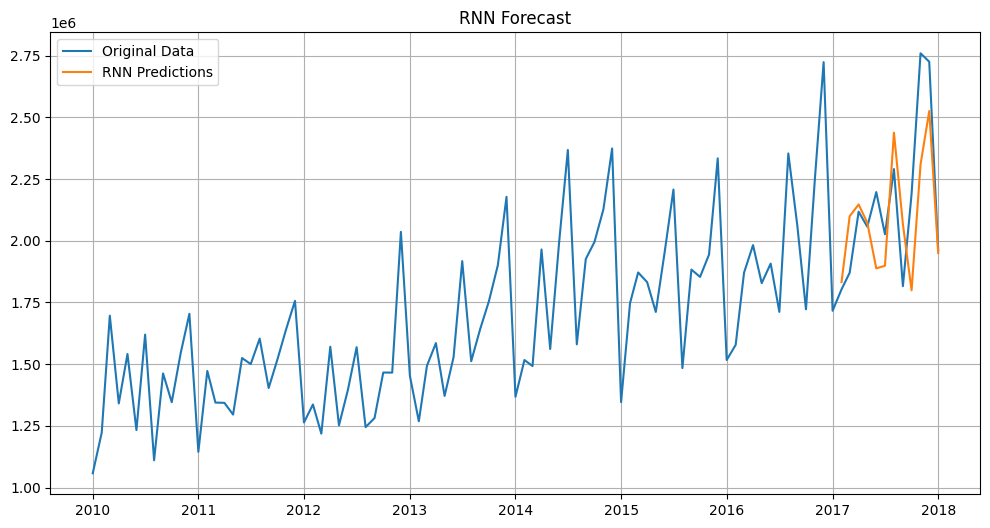

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


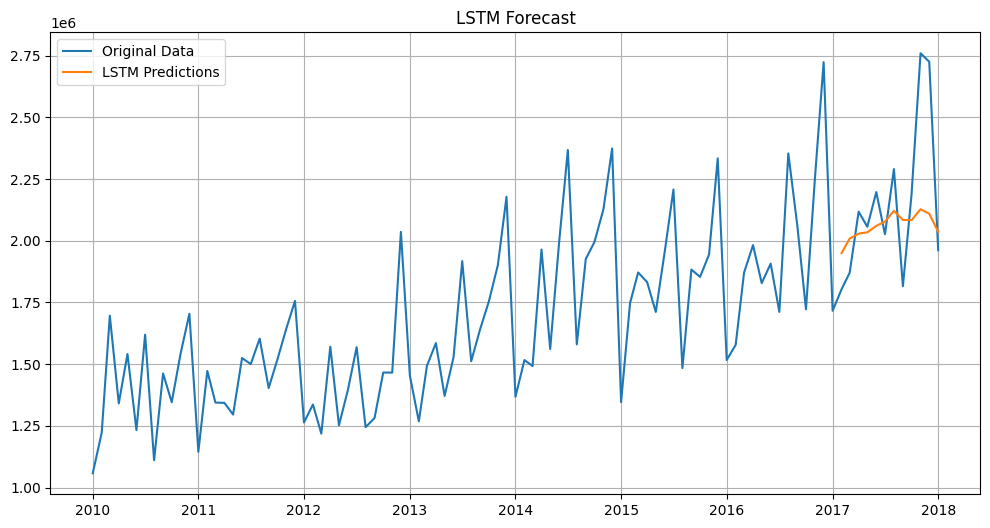

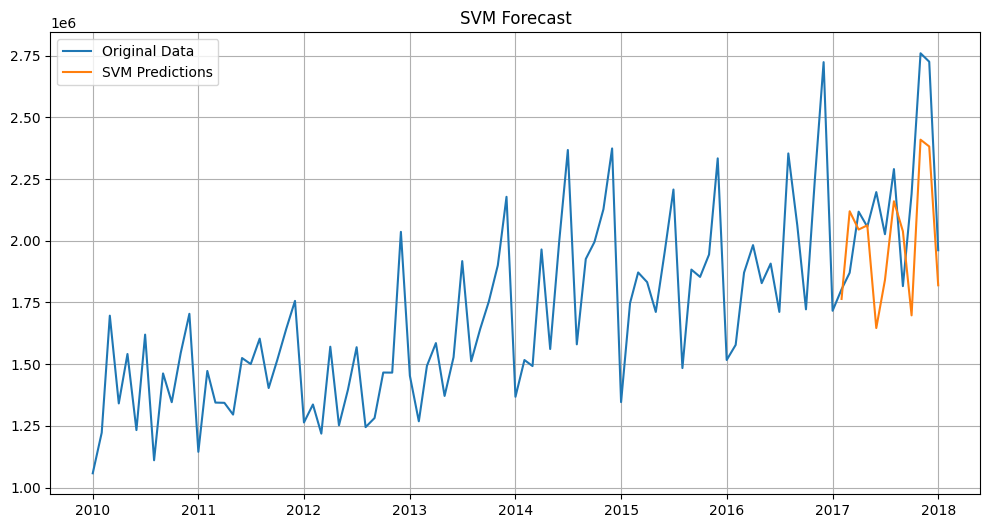

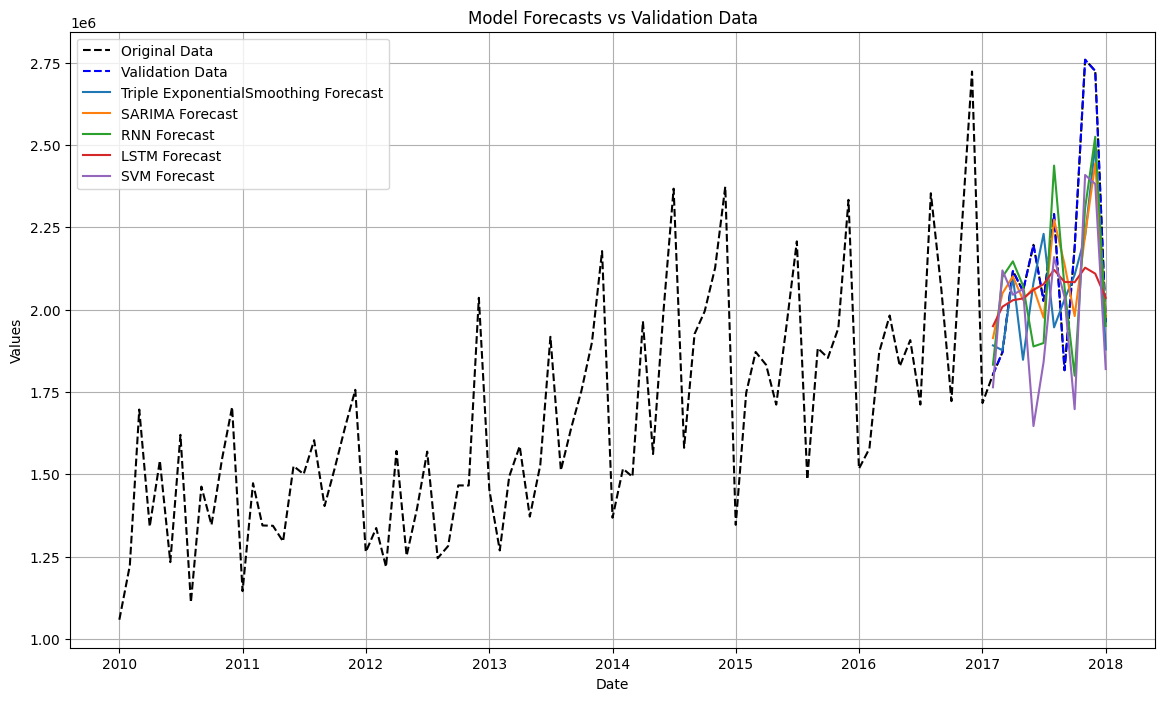

,Original Data,Triple ExponentialSmoothing,SARIMA,RNN,LSTM,SVM
2017-02-01,1803187.17,1891410.20,1913657.06,1832716.50,1949793.88,1764175.33
2017-03-01,1870286.06,1876602.90,2049314.85,2099245.00,2008838.88,2119249.80
2017-04-01,2117629.03,2100053.51,2100963.14,2146760.00,2028665.75,2045190.08
2017-05-01,2056550.76,1847654.85,2029593.56,2072873.00,2033995.12,2062440.12
2017-06-01,2196984.86,2081767.01,2066266.65,1888166.50,2059964.25,1646369.45
2017-07-01,2026293.22,2230209.17,1975605.14,1898612.38,2077302.62,1841139.20
2017-08-01,2290105.04,1946148.58,2273016.86,2437541.25,2120967.25,2159918.84
2017-09-01,1816028.11,2030945.45,2138067.31,2067482.50,2084124.75,2038153.45
2017-10-01,2189198.58,2105971.49,1980407.99,1799272.38,2083350.12,1697647.18
2017-11-01,2759163.58,2222935.67,2226665.47,2309004.50,2127548.25,2409186.93


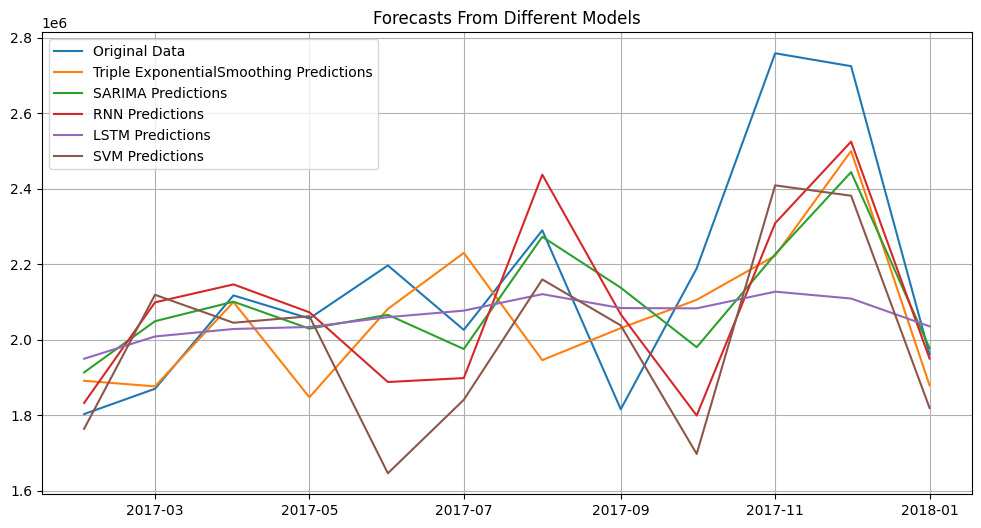


Model Comparison:


,Model,MSE,RMSE,MAPE
0,Triple Exponential Smoothing,51905384433.76,227827.53,7.84
1,SARIMA,47924428130.36,218916.49,7.06
2,RNN,53817918260.03,231986.89,8.23
3,LSTM,80469526185.08,283671.51,8.82
4,SVM,81217454824.65,284986.76,10.52


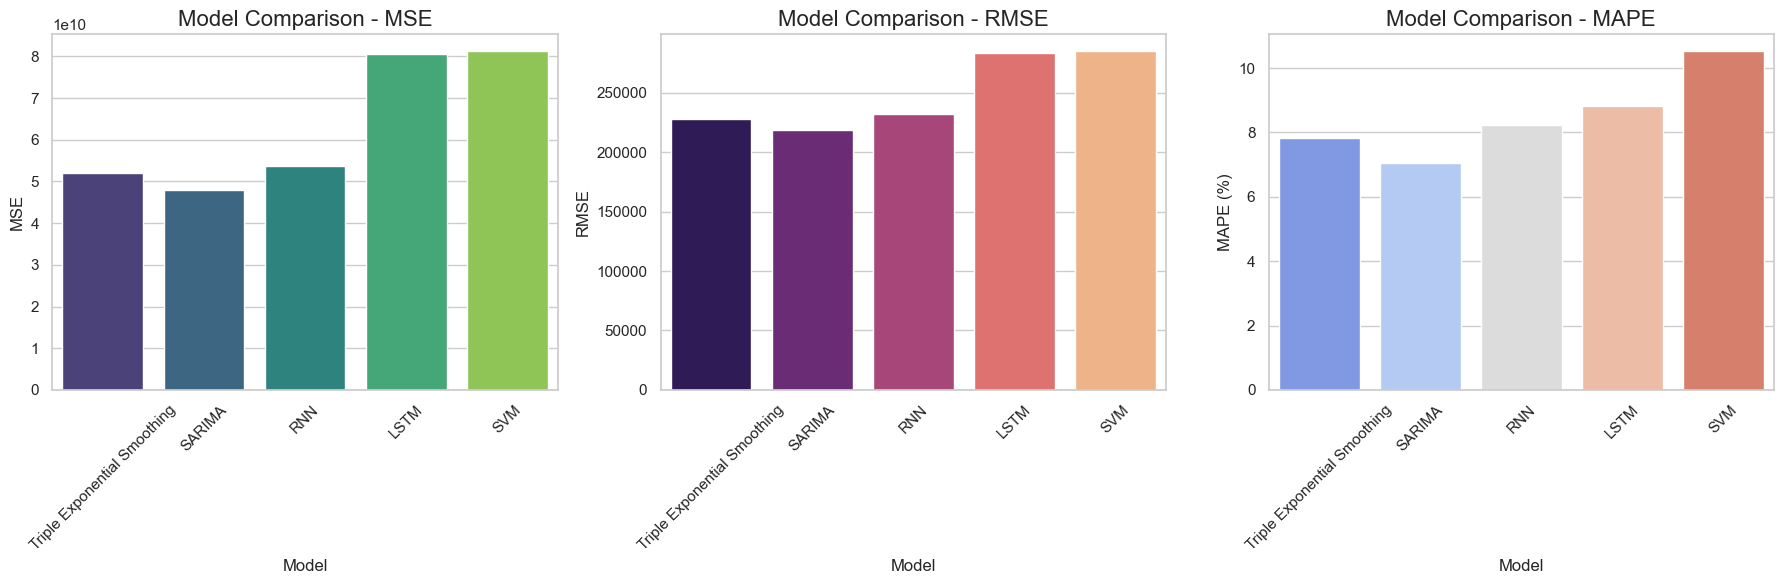

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima
import matplotlib.dates as mdates
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVR
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")

class TimeSeriesForecasting:
    def __init__(self, file_path, date_col, sales_col):
        self.file_path = file_path
        self.date_col = date_col
        self.sales_col = sales_col
        self.data = None
        self.sales_monthly = None
        self.train_data = None
        self.valid_data = None
        self.results = []
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.TIME_STEPS = 12
        self.models = {}

    def preprocess_data(self):
        # Load the data
        self.df = pd.read_csv(self.file_path)
        
        # Automatically detect the date column if not provided
        self.data = self.df[[self.date_col,self.sales_col]]
        self.data[self.date_col] = pd.to_datetime(self.data[self.date_col])
        self.data.set_index(self.date_col, inplace=True)
        

        # Fill missing dates with zero sales
        self.new_index = pd.date_range(self.data.index.min(), self.data.index.max())
        self.sales_data = self.data.reindex(self.new_index, fill_value=0)
        # Resample to monthly data
        self.sales_monthly = self.sales_data.resample('MS').sum().dropna()

    
    def visualize_data(self):
        print("\nThese plots are illustrating the characteristics of the given time series data.")
        self.df_plot = self.sales_monthly.copy()
        fig, axes = plt.subplots(3, 2, figsize=(24, 24))
        axes = axes.flatten()

        # Temporal Visualization (Line Plot)
        axes[0].plot(self.df_plot.index, self.df_plot[self.sales_col], color="blue", label="Data")
        axes[0].set_title("Temporal Visualization (Line Plot)")
        axes[0].set_xlabel("Date")
        axes[0].set_ylabel("Value")
        axes[0].grid()
        axes[0].legend()

        # Distribution Analysis (Histogram)
        sns.histplot(self.df_plot[self.sales_col], bins=30, kde=True, ax=axes[1], color="green")
        axes[1].set_title("Distribution Analysis (Histogram with KDE)")
        axes[1].set_xlabel("Value")
        axes[1].set_ylabel("Frequency")

        # Trend and Seasonality Visualization (Seasonal Decomposition)
        decomposition = seasonal_decompose(self.df_plot[self.sales_col], model='additive')
        decomposition.trend.plot(ax=axes[2], color="red", label="Trend")
        decomposition.seasonal.plot(ax=axes[2], color="purple", label="Seasonal Component")
        axes[2].set_title("Trend and Seasonality Visualization")
        axes[2].grid()
        axes[2].legend()

        # Yearly Histogram
        self.df_plot['Year'] = self.df_plot.index.year
        yearly_sales = self.df_plot.groupby('Year')[self.sales_col].sum()  # Summing sales for each year

        # Remove the last year from the data
        filtered_yearly_sales = yearly_sales.iloc[:-1]  # Exclude the last year

        axes[3].bar(filtered_yearly_sales.index, filtered_yearly_sales.values, color="orange")
        axes[3].set_title("Yearly Data Histogram (Excluding Last Year)")
        axes[3].set_xlabel("Year")
        axes[3].set_ylabel("Total Values")
        axes[3].grid()

        # Monthly Box Plot with different colors for each month
        axes[4].set_title("Monthly Box Plot")
        month_colors = sns.color_palette("Set3", 12) 
        sns.boxplot(x=self.df_plot.index.month, y=self.df_plot[self.sales_col], ax=axes[4], palette=month_colors)
        axes[4].set_xlabel("Month")
        axes[4].set_ylabel("Values")
        axes[4].set_xticklabels([
        "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
        ])
        

        # Threshold Highlighting Plot
        threshold = self.df_plot[self.sales_col].quantile(0.75)  # 75th percentile
        axes[5].plot(self.df_plot.index, self.df_plot[self.sales_col], label="Values", color="blue")
        axes[5].axhline(threshold, color='red', linestyle='--', label="Threshold")
        axes[5].fill_between(self.df_plot.index, self.df_plot[self.sales_col], threshold, where=(self.df_plot[self.sales_col] > threshold), color="yellow", alpha=0.3)
        axes[5].set_title("Threshold Highlighting Plot")
        axes[5].legend()
        axes[5].set_xlabel("Date")
        axes[5].set_ylabel("Values")
        axes[5].grid()


        
        # Layout adjustment
        fig.tight_layout()
        plt.subplots_adjust(hspace=0.5)
        plt.show()

      
    
    def split_data(self, valid_size=12):
        self.train_data = self.sales_monthly[:-valid_size]
        self.valid_data = self.sales_monthly[-valid_size:]


    def check_stationarity(self, series):
        result = adfuller(series)
        print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")
        return result[1] <= 0.05

    def plot_model_forecast(self, model_name, predictions):
        # Plot original and predictions for each model
        plt.figure(figsize=(12, 6))
        plt.plot(self.sales_monthly, label="Original Data")
        forecast_index = pd.date_range(start=self.valid_data.index[0], periods=len(self.valid_data), freq='MS')
        plt.plot(forecast_index, predictions, label=f"{model_name} Predictions")
        plt.legend()
        plt.title(f"{model_name} Forecast")
        plt.grid()
        plt.show()
        

    def exponential_smoothing(self):
        # Ensure train_data is valid
        if self.train_data is None or self.train_data.empty:
            raise ValueError("Training data is not initialized. Call split_data before running models.")
        
        model = ExponentialSmoothing(
            self.train_data[self.sales_col], 
            damped_trend=True, 
            trend="add",
            seasonal="add", 
            seasonal_periods=12
        ).fit(optimized=True)
        preds = model.forecast(len(self.valid_data))
        mse = mean_squared_error(self.valid_data[self.sales_col], preds)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(self.valid_data[self.sales_col], preds) * 100
        self.models["Triple ExponentialSmoothing"] = {"Model": model, "Predictions": preds}
        self.results.append(["Triple Exponential Smoothing", mse, rmse, mape])
        self.plot_model_forecast("Triple Exponential Smoothing", preds)

    def sarima_model(self):
        # Fit SARIMA model
        sarima = auto_arima(
            self.train_data[self.sales_col],
            seasonal=True, m=12,
            trace=False, suppress_warnings=True
        )

        # Forecast and get confidence intervals
        forecast, conf_int = sarima.predict(n_periods=len(self.valid_data), return_conf_int=True)

        # Calculate metrics
        mse = mean_squared_error(self.valid_data[self.sales_col], forecast)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(self.valid_data[self.sales_col], forecast) * 100

        # Save model and forecast results
        self.models["SARIMA"] = {"Model": sarima, "Predictions": forecast}
        self.results.append(["SARIMA", mse, rmse, mape])

        # Plot the forecast with confidence intervals
        forecast_index = pd.date_range(self.valid_data.index[0], periods=len(self.valid_data), freq='MS')

        plt.figure(figsize=(12, 6))
        plt.plot(self.sales_monthly, label="Original Data", color="black", linestyle="--")
        plt.plot(forecast_index, forecast, label="SARIMA Forecast", color="blue")
        plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='blue', alpha=0.2, label="Confidence Interval")
        plt.legend()
        plt.title("SARIMA Forecast")
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.grid(True)
        plt.show()


    def create_sequences(self):
        scaled_data = self.scaler.fit_transform(self.sales_monthly[self.sales_col].values.reshape(-1, 1))
        X, y = [], []
        for i in range(len(scaled_data) - self.TIME_STEPS):
            X.append(scaled_data[i:i + self.TIME_STEPS])
            y.append(scaled_data[i + self.TIME_STEPS])
        X, y = np.array(X), np.array(y)
        return X[:-12], y[:-12], X[-12:], y[-12:]

    def rnn_model(self):
        X_train, y_train, X_valid, y_valid = self.create_sequences()
        rnn_model = Sequential([
            SimpleRNN(50, activation='tanh', return_sequences=True, input_shape=(self.TIME_STEPS, 1)),
            Dropout(0.2),
            SimpleRNN(50, activation='tanh'),
            Dropout(0.2),
            Dense(1)
        ])
        rnn_model.compile(optimizer='adam', loss='mean_squared_error')
        rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        preds = rnn_model.predict(X_valid)
        preds_rescaled = self.scaler.inverse_transform(preds)
        y_valid_rescaled = self.scaler.inverse_transform(y_valid.reshape(-1, 1))
        mse = mean_squared_error(y_valid_rescaled, preds_rescaled)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_valid_rescaled, preds_rescaled) * 100
        self.models["RNN"] = {"Model": rnn_model, "Predictions": preds_rescaled.flatten()}
        self.results.append(["RNN", mse, rmse, mape])
        self.plot_model_forecast("RNN", preds_rescaled)

    def lstm_model(self):
        X_train, y_train, X_valid, y_valid = self.create_sequences()
        lstm_model = Sequential([
            LSTM(100, activation='tanh', return_sequences=True, input_shape=(self.TIME_STEPS, 1)),
            Dropout(0.2),
            LSTM(100, activation='tanh', return_sequences=True),
            Dropout(0.2),
            LSTM(50, activation='tanh'),
            Dropout(0.2),
            Dense(1)
        ])
        optimizer = Adam(learning_rate=0.0005)
        lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')
        lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
        preds = lstm_model.predict(X_valid)
        preds_rescaled = self.scaler.inverse_transform(preds)
        y_valid_rescaled = self.scaler.inverse_transform(y_valid.reshape(-1, 1))
        mse = mean_squared_error(y_valid_rescaled, preds_rescaled)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_valid_rescaled, preds_rescaled) * 100
        self.models["LSTM"] = {"Model": lstm_model, "Predictions": preds_rescaled.flatten()}
        self.results.append(["LSTM", mse, rmse, mape])
        self.plot_model_forecast("LSTM", preds_rescaled)

    def svm_model(self):
        X_train, y_train, X_valid, y_valid = self.create_sequences()

        # Flatten data for SVM
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
        y_train_flat = y_train.flatten()
        y_valid_flat = y_valid.flatten()

        # Define the SVM model with parameters
        svm_model = SVR(kernel='rbf')

        # Set up the parameter grid for hyperparameter tuning
        param_grid = {
            'C': [0.1, 1, 10],  
            'epsilon': [0.01, 0.1, 0.2],
            'gamma': ['scale', 'auto']  
        }

        # Perform GridSearchCV to find the best parameters
        grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_flat, y_train_flat)

        # Get the best model with optimized parameters
        best_model = grid_search.best_estimator_

        # Make predictions using the best model
        preds = best_model.predict(X_valid_flat)

        # Rescale predictions and true values
        preds_rescaled = self.scaler.inverse_transform(preds.reshape(-1, 1))
        y_valid_rescaled = self.scaler.inverse_transform(y_valid_flat.reshape(-1, 1))

        # Calculate performance metrics
        mse = mean_squared_error(y_valid_rescaled, preds_rescaled)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_valid_rescaled, preds_rescaled) * 100

        # Store the model and predictions
        self.models["SVM"] = {"Model": best_model, "Predictions": preds_rescaled}
        self.results.append(["SVM", mse, rmse, mape])

        # Plot the forecast
        self.plot_model_forecast("SVM", preds_rescaled)


    def plot_all_models_forecast(self):
        plt.figure(figsize=(14, 8))

        # Plot original data
        plt.plot(self.sales_monthly, label="Original Data", color="black", linestyle="--")

        # Plot validation data
        plt.plot(self.valid_data.index, self.valid_data[self.sales_col], label="Validation Data", color="blue", linestyle="--")

        # Plot each model's predictions
        for model_name, model_info in self.models.items():
            preds = model_info["Predictions"]
            if isinstance(preds, np.ndarray):  
                preds = preds.flatten()
            forecast_index = pd.date_range(self.valid_data.index[0], periods=len(self.valid_data), freq='MS')
            plt.plot(forecast_index, preds, label=f"{model_name} Forecast")
    
    
    def plot_all_models_forecast(self):
        plt.figure(figsize=(14, 8))

        # Plot original data
        plt.plot(self.sales_monthly, label="Original Data", color="black", linestyle="--")

        # Plot validation data
        plt.plot(self.valid_data.index, self.valid_data[self.sales_col], label="Validation Data", color="blue", linestyle="--")

        # Plot each model's predictions
        for model_name, model_info in self.models.items():
            preds = model_info["Predictions"]
            if isinstance(preds, np.ndarray): 
                preds = preds.flatten()
            forecast_index = pd.date_range(self.valid_data.index[0], periods=len(self.valid_data), freq='MS')
            plt.plot(forecast_index, preds, label=f"{model_name} Forecast")

        plt.legend()
        plt.title("Model Forecasts vs Validation Data")
        plt.xlabel("Date")
        plt.ylabel("Values")
        plt.grid()
        plt.show()
        
    
    def forecast_table(self):
        # Create a DataFrame for the validation data
        forecast_index = pd.date_range(self.valid_data.index[0], periods=len(self.valid_data), freq='MS')
        table = pd.DataFrame(index=forecast_index, columns=["Original Data"])

        table["Original Data"] = self.valid_data.values

        # Loop through each model and add its predictions as a new column
        for model_name, model_info in self.models.items():
            preds = model_info["Predictions"]
            
            table[model_name] = preds.ravel()
        Table = pd.DataFrame(table)
        pd.set_option('display.float_format', '{:.2f}'.format)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        display(Table)
        return table
    
    def plot_forecasts(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.valid_data, label="Original Data")
        for model_name, model_info in self.models.items():
            preds = model_info["Predictions"]
            
            forecast_index = pd.date_range(self.valid_data.index[0], periods=len(self.valid_data), freq='MS')
            plt.plot(forecast_index, preds, label=f"{model_name} Predictions")
        plt.legend()
        plt.title("Forecasts From Different Models")
        plt.grid()
        plt.show()

    def compare_models(self):
        # Generate performance table
        result_df = pd.DataFrame(self.results, columns=["Model", "MSE", "RMSE", "MAPE"])
        print("\nModel Comparison:")
        display(result_df)

        sns.set(style="whitegrid")
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

        # Plot for MSE
        sns.barplot(ax=axes[0], x="Model", y="MSE", data=result_df, palette="viridis")
        axes[0].set_title("Model Comparison - MSE", fontsize=16)
        axes[0].set_ylabel("MSE", fontsize=12)
        axes[0].set_xlabel("Model", fontsize=12)
        axes[0].tick_params(axis='x', rotation=45)

        # Plot for RMSE
        sns.barplot(ax=axes[1], x="Model", y="RMSE", data=result_df, palette="magma")
        axes[1].set_title("Model Comparison - RMSE", fontsize=16)
        axes[1].set_ylabel("RMSE", fontsize=12)
        axes[1].set_xlabel("Model", fontsize=12)
        axes[1].tick_params(axis='x', rotation=45)

        # Plot for MAPE
        sns.barplot(ax=axes[2], x="Model", y="MAPE", data=result_df, palette="coolwarm")
        axes[2].set_title("Model Comparison - MAPE", fontsize=16)
        axes[2].set_ylabel("MAPE (%)", fontsize=12)
        axes[2].set_xlabel("Model", fontsize=12)
        axes[2].tick_params(axis='x', rotation=45)

        # Adjust layout
        plt.tight_layout()
        plt.show()

        
        
    def run_all_models(self):
        self.preprocess_data()
        self.visualize_data()
        self.split_data(valid_size=12)
        self.exponential_smoothing()
        self.sarima_model()
        self.rnn_model()
        self.lstm_model()
        self.svm_model()
        self.plot_all_models_forecast()
        self.forecast_table()
        self.plot_forecasts()
        self.compare_models()
        
        
### Running the Data Series Used in the study ###
file_path = 'data.csv'
date_col = 'Date'
sales_col = 'Sales'
forecasting = TimeSeriesForecasting(file_path,date_col, sales_col)
forecasting.run_all_models()